## 分析
這邊試圖處理的問題是：標註為惡意的log與標註為良性的log在語意(sementic)上是否有所不同?
這邊關係到強化學習的代理Agent能否有效地找到標註為惡意的log(可以分辨出某些惡意行為與其他行為不同)並且標上正確的TTP標籤(找出攻擊的方法)

## 方法
嘗試了兩種類型的方法，純粹的詞意與轉換成Provenance Graph後再進行嵌入轉換

In [17]:
import os
import json
import re
import umap
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# =========================
# Path settings
# =========================
pathSAGA = os.path.join("D:\\", "dataset", "SAGA")
pathSAGAG16 = os.path.join(pathSAGA,"Generated APT Campaigns Dataset" ,"G16.json")
pathCasinoLimit = os.path.join("D:\\", "dataset", "CasinoLimit")

print("SAGA exists:", os.path.exists(pathSAGA))

SAGA exists: True


In [3]:

# =========================
# Load dataset
# =========================
def load_saga_json(path):
    with open(path, "r", encoding="utf-8") as file:
        l = []
        for i in file:
           l.append(json.loads(i)) 
    return l
saga_logs = load_saga_json(pathSAGAG16)


In [4]:
def log_to_embedding_text(log):
    """
    Convert a single audit / graph log to a semi-structured text
    (label must NOT be used here)
    """

    src = log.get("srcNode") or {}
    dst = log.get("dstNode") or {} 
    relation = log.get("relation", "unknown")

    proc_name = src.get("Name", "")
    proc_path = src.get("Image", "")
    action = relation

    dst_type = dst.get("Type", "")
    dst_key = dst.get("Key", "") or dst.get("Name", "")

    # simple abstraction
    if proc_path and (
        "System32" in proc_path or "Program Files" in proc_path
    ):
        proc_category = "system process"
    else:
        proc_category = "user process"

    text = f"""
Process: {proc_name}
Category: {proc_category}
Action: {action}
Target type: {dst_type}
Target description: {dst_key}
""".strip()

    return text

In [11]:
log_to_embedding_text(saga_logs[0])

'Process: vmtoolsd.exe\nCategory: system process\nAction: RegQueryValue\nTarget type: Registry\nTarget description: HKLM\\System\\CurrentControlSet\\Services\\Dnscache\\Parameters\\DisableIdnEncoding'

In [5]:
print("Total logs:", len(saga_logs))

# =========================
# Prepare embedding inputs
# =========================
embedding_texts = []
labels = []   # only used for coloring later

for log in tqdm(saga_logs):
    #print(log)
    embedding_text = log_to_embedding_text(log)
    #print(mbedding_text)
    embedding_texts.append(embedding_text)

    labels.append(log.get("label", "unknown"))



Total logs: 86357


100%|██████████| 86357/86357 [00:00<00:00, 600272.64it/s]


In [ ]:

# =========================
# Embedding
# =========================
print("Embedding logs...")
model = SentenceTransformer("cisco-ai/SecureBERT2.0-biencoder")
embeddings = model.encode(embedding_texts, show_progress_bar=True)
embeddings = np.array(embeddings)

In [13]:
df_ttp = df[df["label"] == "TTP"]
print("TTP count:", (df["label"] == "TTP").sum())
print(df["label"].value_counts())


TTP count: 0
label
benign                                        86235
T1574.001_63bbedafba2f541552ac3579e9e3737b       64
T1083_52177cc1-b9ab-4411-ac21-2eadc4b5d3b8       21
T1105_4f683658f161ccdc51337c470d32bab9           10
T1566.001_1afaec09315ab71fdfb167175e8a019a        9
T1003_18f31c311ac208802e88ab8d5af8603e            7
T1003.002_7fa4ea18694f2552547b65e23952cabb        5
T1112_fd992e8ecfdac9b56dd6868904044827            3
T1204.002_522f3f35cd013e63830fa555495a0081        1
T1016_a0676fe1-cd52-482e-8dde-349b73f9aa69        1
T1490_e90756bb6dcd21462dc4cc452661df91            1
Name: count, dtype: int64


Number of TTP events: 122
Number of TTP classes: 10


C:\Users\nick5\AppData\Local\Temp\ipykernel_20272\1093692205.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(ttp_labels))


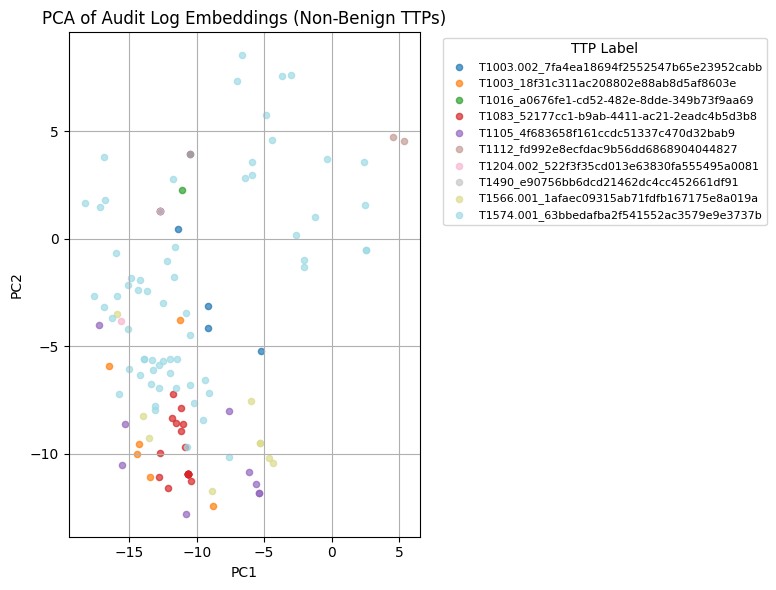

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# 只保留非 benign
df_ttp = df[df["label"] != "benign"]

print("Number of TTP events:", len(df_ttp))
print("Number of TTP classes:", df_ttp["label"].nunique())

# 取得所有 TTP 類別
ttp_labels = sorted(df_ttp["label"].unique())

# 自動產生顏色（tab20 很適合離散類別）
cmap = cm.get_cmap("tab20", len(ttp_labels))

plt.figure(figsize=(8, 6))

for i, lbl in enumerate(ttp_labels):
    subset = df_ttp[df_ttp["label"] == lbl]
    plt.scatter(
        subset["x"],
        subset["y"],
        color=cmap(i),
        label=lbl,
        alpha=0.7,
        s=20
    )

plt.title("PCA of Audit Log Embeddings (Non-Benign TTPs)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)

# TTP 類別多，legend 放外面
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=8,
    title="TTP Label"
)

plt.tight_layout()
plt.show()

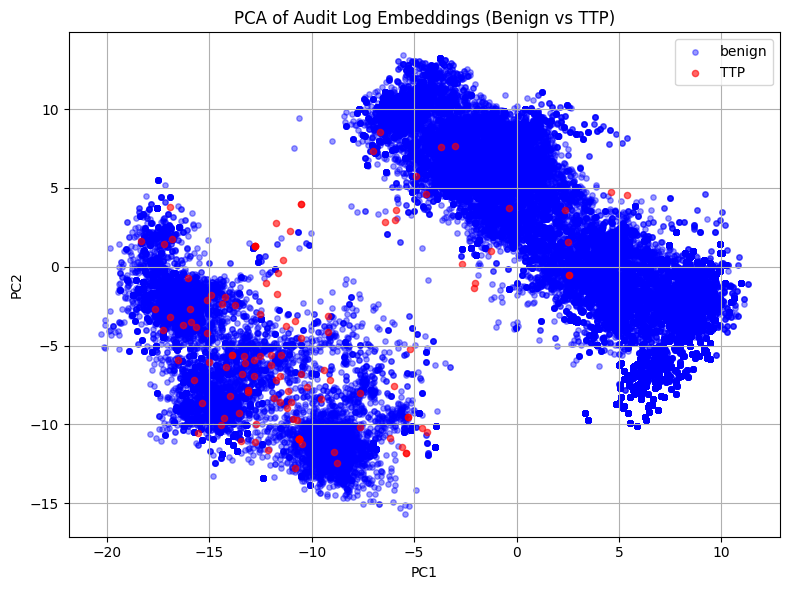

In [15]:
# =========================
# Visualization (Benign vs TTP)
# =========================

# 建立顏色欄位
df["color"] = df["label"].apply(
    lambda x: "blue" if x == "benign" else "red"
)

plt.figure(figsize=(8, 6))

# Benign
subset_benign = df[df["label"] == "benign"]
plt.scatter(
    subset_benign["x"],
    subset_benign["y"],
    color="blue",
    alpha=0.4,
    s=15,
    label="benign"
)

# Non-benign (all TTP)
subset_ttp = df[df["label"] != "benign"]
plt.scatter(
    subset_ttp["x"],
    subset_ttp["y"],
    color="red",
    alpha=0.6,
    s=20,
    label="TTP"
)

plt.legend()
plt.title("PCA of Audit Log Embeddings (Benign vs TTP)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


### UMAP

Running UMAP...


c:\Users\nick5\anaconda3\envs\FG\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\nick5\anaconda3\envs\FG\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\nick5\anaconda3\envs\FG\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\nick5\anaconda3\envs\FG\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to you

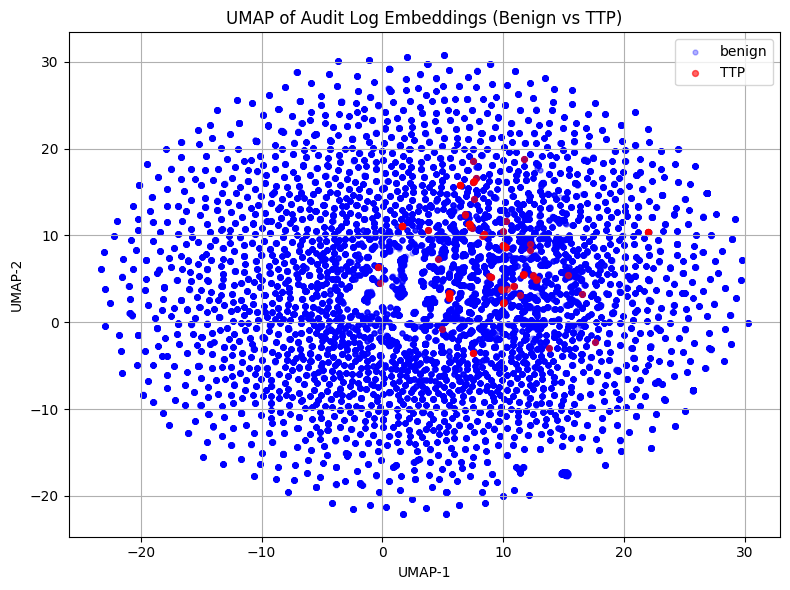

In [18]:

# =========================
# UMAP
# =========================
print("Running UMAP...")

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

emb_2d_umap = umap_model.fit_transform(embeddings)

df_umap = pd.DataFrame({
    "x": emb_2d_umap[:, 0],
    "y": emb_2d_umap[:, 1],
    "label": labels
})

plt.figure(figsize=(8, 6))

# benign
plt.scatter(
    df_umap[df_umap["label"] == "benign"]["x"],
    df_umap[df_umap["label"] == "benign"]["y"],
    color="blue",
    alpha=0.3,
    s=12,
    label="benign"
)

# TTP (non-benign)
plt.scatter(
    df_umap[df_umap["label"] != "benign"]["x"],
    df_umap[df_umap["label"] != "benign"]["y"],
    color="red",
    alpha=0.6,
    s=18,
    label="TTP"
)

plt.legend()
plt.title("UMAP of Audit Log Embeddings (Benign vs TTP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()

### t-SNE

Running t-SNE...


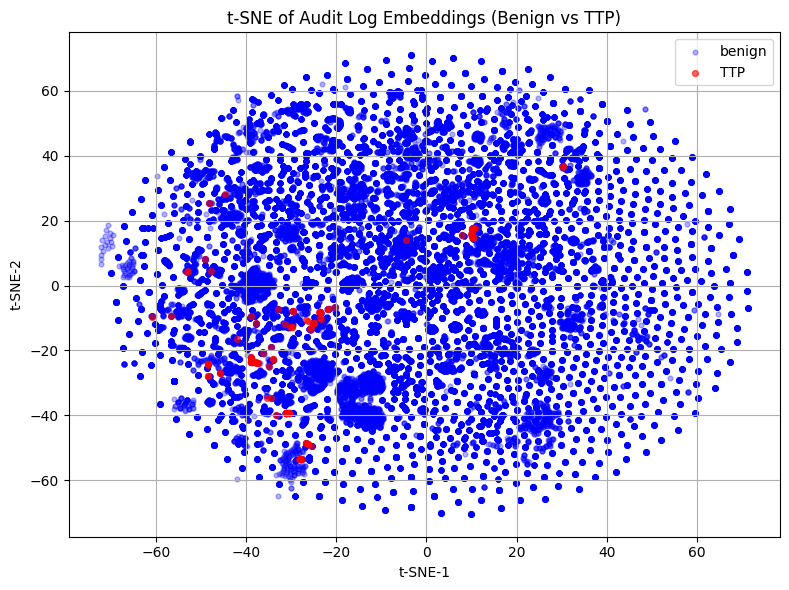

In [20]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# t-SNE
# =========================
print("Running t-SNE...")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    metric="cosine",
    random_state=42
)

emb_2d_tsne = tsne.fit_transform(embeddings)

df_tsne = pd.DataFrame({
    "x": emb_2d_tsne[:, 0],
    "y": emb_2d_tsne[:, 1],
    "label": labels
})

plt.figure(figsize=(8, 6))

# benign
plt.scatter(
    df_tsne[df_tsne["label"] == "benign"]["x"],
    df_tsne[df_tsne["label"] == "benign"]["y"],
    color="blue",
    alpha=0.3,
    s=12,
    label="benign"
)

# TTP (non-benign)
plt.scatter(
    df_tsne[df_tsne["label"] != "benign"]["x"],
    df_tsne[df_tsne["label"] != "benign"]["y"],
    color="red",
    alpha=0.6,
    s=18,
    label="TTP"
)

plt.legend()
plt.title("t-SNE of Audit Log Embeddings (Benign vs TTP)")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True)
plt.tight_layout()
plt.show()

- 以上都是針對某個檔案做的(SAGA資料集的G16.json)